<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/77_Pro_Pytorch_%D0%A7%D0%B0%D1%81%D1%82%D1%8C_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Pro

Макс 10 баллов

Напишите модель автокодировщика для любой из баз, представленных в torchvision.

In [ ]:
# Этим блоком будем визуализировать
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from PIL import Image
import scipy

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежат mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.nn.functional as F
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms # библиотека для преобразования изображений
import torchvision.datasets as dsets # работа с классом Датасет
from torch.utils.data import SubsetRandomSampler
# Вывод информации о модели
from torchsummary import summary

# Визуализации графа
from torch.utils.tensorboard import SummaryWriter 
import datetime, os
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Загрузка MNIST**



Задаем параметры

In [ ]:
numEpochs = 30       # Количество эпох
learningRate = 0.001 # Скорость обучения

Загружаем данные 

In [ ]:
batchSize = 32

In [ ]:
def get_dataloaders_mnist(batch_size, num_workers=0,
                          validation_fraction=None,
                          train_transforms=None, test_transforms=None):

    if train_transforms is None:                                 # если не выбрана трансформация на обучающем датасете
        train_transforms = transforms.ToTensor()                 # По умолчанию ToTensor() 

    if test_transforms is None:                                  # если не выбрана трансформация на тестовом датасете
        test_transforms = transforms.ToTensor()                  # По умолчанию ToTensor()

    train_dataset = dsets.MNIST(root='data',                     # Загружаем данные обучающей выборки
                                   train=True,
                                   transform=train_transforms,
                                   download=True)

    valid_dataset = dsets.MNIST(root='data',                     # Загружаем данные валидационной выборки выборки
                                   train=True,
                                   transform=test_transforms)

    test_dataset = dsets.MNIST(root='data',                      # Загружаем данные тестовой выборки
                                  train=False,
                                  transform=test_transforms)

    if validation_fraction is not None:                          # Если валидационный набор нужен
        num = int(validation_fraction * 60000)                   # В переменную num сохраняем кол-во примеров, а в функции укажем долю (например 0.2) * 60 000
        train_indices = torch.arange(0, 60000 - num)             # В обучающий забор запишем первые примеры до значения num
        valid_indices = torch.arange(60000 - num, 60000)         # В валидационный набор запишем примеры идущие после значения num

        train_sampler = SubsetRandomSampler(train_indices)       # Семплируем/сплитуем элементы в одинаковой последовательности обучающего набора данных
        valid_sampler = SubsetRandomSampler(valid_indices)       # Семплируем/сплитуем примеры в одинаковой последовательности валидвционного набора данных

        valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, # Dataset Loader (подготовка валидационных данных для сети)
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  sampler=valid_sampler)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, # Dataset Loader (подготовка обучающих данных для сети)
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  drop_last=True,
                                  sampler=train_sampler)
    else:                                                                 # В противном случае делим набор на обучающий и тестовый
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  num_workers=num_workers,
                                  shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False)

    if validation_fraction is None:                       # Если валидационный набор не нужен 
        return train_loader, test_loader                  # Возвращаем обучающий и тестовый наборы данных
    else:                                                 # В противном случае возвращаем обучающий, валидационный и тестовый наборы
        return train_loader, valid_loader, test_loader

In [ ]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(   # загружаем три набора: train_loader, valid_loader, test_loader
    batch_size=batchSize,  
    num_workers=2, 
    validation_fraction=0.)

In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:                  # Пробегаемся по примерам в батчах и меткам в обучающем генераторе
    print('Image batch dimensions:', images.size())  # Выводим размер батча примеров
    print('Image label dimensions:', labels.size())  # Выводим размер батча меток
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([8, 4, 0, 5, 4, 1, 8, 9, 8, 4])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


# Сверточная сеть




In [ ]:
# Создадим переменную, в которой будет храниться тип устройства (GPU или CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):        # Создадим слой Reshape объект класса Module 
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):           # Создадим слой для изменения размерности выхода на размерность (:, :, :28, :28)
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):   # Создаем слои автоэнкодера из 2х блоков
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = AutoEncoder()  # Инициируем модель
model.to(device)       # Передаем модель на GPU  

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=3136, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3136, bias=True)
    (1): Reshape()
    (2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): LeakyR

In [ ]:
summary(model, (1,28,28))  # Посмотрим схему автоэнкодера

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5             [-1, 64, 7, 7]          36,928
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7             [-1, 64, 7, 7]          36,928
           Flatten-8                 [-1, 3136]               0
            Linear-9                    [-1, 2]           6,274
           Linear-10                 [-1, 3136]           9,408
          Reshape-11             [-1, 64, 7, 7]               0
  ConvTranspose2d-12             [-1, 64, 7, 7]          36,928
        LeakyReLU-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

In [ ]:
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)  

# Обучение

In [ ]:
# Функция для оценки потерь на эпохе, принимает на вход модель, генератор загрузки данных (train_loader, valid_loader, test_loader), loss функцию, device
def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()                                                # Переводим модель в тестовый режим
    curr_loss, num_examples = 0., 0                             # Стартовые значения текущего loss'a, кол-во примеров 
    with torch.no_grad():                                       # Отключаем расчет градиентов
        for features, _ in data_loader:                         # Пробегаемся по батчам датасета 
            features = features.to(device)                      # Передаем данные из датасета на device
            logits = model(features)                            # Записываем в перменную logits наше предсказание на батче
            loss = loss_fn(logits, features, reduction='sum')   # Считаем ошибку 
            num_examples += features.size(0)                    # Увеличиваем кол-во примеров на батч
            curr_loss += loss                                   # Добавляем значение ошибки на батче к общему

        curr_loss = curr_loss / num_examples                    # Считаем loss на эпохе
        return curr_loss                                        # Возвращает loss на эпохе


In [ ]:
# Функция обучения автоэнкодера принимает на вход num_epochs - к-во эпох, model - модель, optimizer - оптимизатор, device, train_loader - обучающий набор данных,
#  loss_fn=None лосс функцию, logging_interval=100 интервал через который выводим инфо по результатам обучения, skip_epoch_stats=False нужно ли выводить доп инфо, save_model=None нужно ли созранить модель
def train_autoencoder_v1(num_epochs, model, optimizer, device, 
                         train_loader, loss_fn=None,
                         logging_interval=100, 
                         skip_epoch_stats=False,
                         save_model=None):
    
    log_dict = {'train_loss_per_batch': [],                         # Объявим словарь данных по ошибкам на батче и на эпохе
                'train_loss_per_epoch': []}
    
    if loss_fn is None:                                             # Если лосс функция не задана, по умолчанию MSE
        loss_fn = F.mse_loss                      

    start_time = time.time()                                        # Засекаем время
    for epoch in range(num_epochs):                                 # Пробегаемся по всем эпохам

        model.train()                                               # Переводим модель в режим обучения
        for batch_idx, (features, _) in enumerate(train_loader):    # Проходимся по всем данным в batch

            features = features.to(device)                          # Отправляем примеры на используемое устройство

            # FORWARD AND BACK PROP
            logits = model(features)                                # Делаем предсказание на батче
            loss = loss_fn(logits, features)                        # Считаем лосс
            optimizer.zero_grad()                                   # Обнуляем градиенты

            loss.backward()                                         # Делаем обратный проход

            # UPDATE MODEL PARAMETERS
            optimizer.step()                                        #  Изменяем значения весов

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())    # Добавляем в словарь значение ошибки на батче 
            
            if not batch_idx % logging_interval:                    # Если пройден интервал = 100
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f' # Выводим инфо по результатам обучения
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:                 # Если skip_epoch_stats = True          
            model.eval()                         # Переводим модель в тестовый режим 
            
            with torch.set_grad_enabled(False):  # save memory during inference / отключаем расчет градиентов
                
                train_loss = compute_epoch_loss_autoencoder(                    # Записываем в переменную train_loss значение ошибки на обучении
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.3f' % (                    # Выводим на экран номер эпохи/ из к-ва эпох, лосс на обучении
                      epoch+1, num_epochs, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())      # Добавляем в словарь значение лосса на эпохе

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))       # Выводим инфо о времени обучения на эпохе

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))    # Выводим общее время обучения 
    if save_model is not None:                                                  # Если нужно сохранить модель 
        torch.save(model.state_dict(), save_model)                              # Сохраняем только параметры модели (в целях безопасности)
    
    return log_dict # Функция возвращает словарь с loss'ами                                                              


In [ ]:
log_dict = train_autoencoder_v1(num_epochs=numEpochs, model=model, 
                                optimizer=optimizer, device=device, 
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/030 | Batch 0000/1875 | Loss: 0.1890
Epoch: 001/030 | Batch 0250/1875 | Loss: 0.0523
Epoch: 001/030 | Batch 0500/1875 | Loss: 0.0517
Epoch: 001/030 | Batch 0750/1875 | Loss: 0.0522
Epoch: 001/030 | Batch 1000/1875 | Loss: 0.0461
Epoch: 001/030 | Batch 1250/1875 | Loss: 0.0494
Epoch: 001/030 | Batch 1500/1875 | Loss: 0.0447
Epoch: 001/030 | Batch 1750/1875 | Loss: 0.0419
Time elapsed: 0.79 min
Epoch: 002/030 | Batch 0000/1875 | Loss: 0.0455
Epoch: 002/030 | Batch 0250/1875 | Loss: 0.0405
Epoch: 002/030 | Batch 0500/1875 | Loss: 0.0400
Epoch: 002/030 | Batch 0750/1875 | Loss: 0.0398
Epoch: 002/030 | Batch 1000/1875 | Loss: 0.0442
Epoch: 002/030 | Batch 1250/1875 | Loss: 0.0486
Epoch: 002/030 | Batch 1500/1875 | Loss: 0.0436
Epoch: 002/030 | Batch 1750/1875 | Loss: 0.0327
Time elapsed: 1.65 min
Epoch: 003/030 | Batch 0000/1875 | Loss: 0.0413
Epoch: 003/030 | Batch 0250/1875 | Loss: 0.0384
Epoch: 003/030 | Batch 0500/1875 | Loss: 0.0402
Epoch: 003/030 | Batch 0750/1875 | Loss: 0

# Вывод результатов обучения

In [ ]:
# Функция вывода графика обучения
def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    ax1.set_ylim([
        0, np.max(minibatch_losses[num_losses:])*1.5
        ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()
    

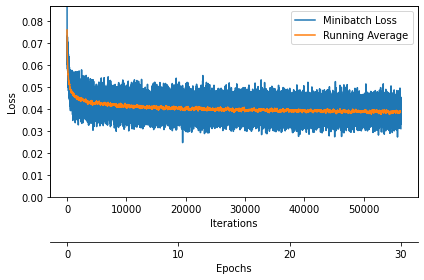

In [ ]:
plot_training_loss(log_dict['train_loss_per_batch'], numEpochs)
plt.show()

In [ ]:
# Функция вывода исходных картинок и выходов автоэнкодера
def plot_generated_images(data_loader, model, device, 
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (features, _) in enumerate(data_loader):
        
        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]
        
        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))        
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')
                
                
def plot_latent_space_with_labels(num_classes, data_loader, model, device):
    d = {i:[] for i in range(num_classes)}

    model.eval()
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)
            
            embedding = model.encoder(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

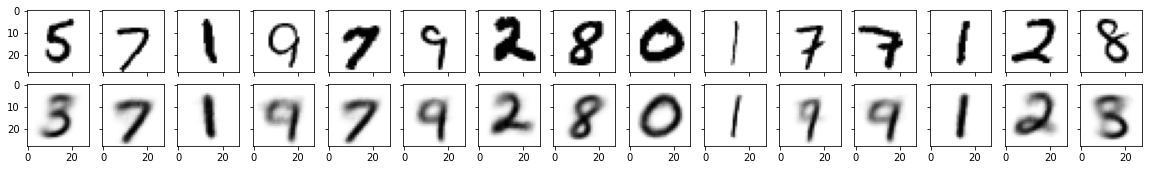

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=device)   

Решение найдено по ссылке https://www.youtube.com/watch?v=345wRyqKkQ0&t=483s

# **Глоссарий**
*   **train dataset** - объект, включающий в себя ваш набор данных. На выходе такого объекта всегда должен быть тензор.
*   **train loader** - объект, в который вы подгружаете ваш train dataset, и который используете при обучении нейронной сети для итерирования по всему набору данных. 
*   **optimizer.zero_grad()** - обнуляет результат дифференциирования.
*   **loss.backward()** - считает градиент для обратного распространения ошибки. 
*   **optimizer.step()** - принимает (автоматически) посчитанные градиенты и делает шаг оптимизации.
*   **nn.Module** - базовый класс нейронной сети, на котором строится собственная нейронная сеть.
*   **def forward(self,x)** - функция-движитель. Связывает инициализированные слои. На вход принимается х (batch) и передается дальше по всем слоям.
*   **data.Dataset** -  базовый класс дата сета, на котором строится собственный датасет.
*   **.view()** - функция, интерпретирующая размер объекта для данной итерации в том виде, который указан в качестве параметра.
*   **.data** - получить исключительно статичные данные из тензора.
*   **.detach()** - открепить тензор от вычислительного графа.
*   **model.train()** - перевести объект нейронки в обучающи режим.
*   **model.eval()** - перевести объект нейронки в режим оценки.

# **Обратите внимание**

*   В параметрах тензора вы можете вручную прописать поддержку дифференциирования
*   Для удобства всегда создавайте DataLoader. Для DataLoader необходим Dataset
*   Dataset всегда можно прописать "вручную"
*   Прописываете архитектуру модели через отдельный класс
*   Выбирая функцию ошибки, смотрите, какой формат должен подаваться на вход
*   Во время обучения не забывайте о последовательности .zero_grad -> .backward -> .step
*   Режимы тренировочный и оценочный являются *разными* для Pytorch. Не забывайте указывать это в начале.    


